In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def K(x, sigma=1, dim=7):
    w = np.linalg.norm(x, ord=2)
    return np.exp(-w ** 2 / 2 / sigma**2) / (2 * np.pi * sigma**2)**(dim/2)

In [3]:
df = pd.read_csv('kc_house_data_NaN.csv').iloc[:, 1:]

# Feature Processing

In [4]:
area_feature = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
year_feature = ['yr_built', 'yr_renovated']
other_feature = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

In [5]:
df['yr_renovated'] = df.apply(lambda x: x['yr_built'] if x['yr_renovated'] == 0 else x['yr_renovated'], axis=1)
df.drop(15870) # an outlier
df = df.dropna().reset_index(drop=True)
df.iloc[:, 2:] = df.iloc[:, 2:].astype('float')

In [6]:
# split dataset
np.random.seed(42)
shuffle_index = np.random.permutation(len(df))
train_dataset = df.loc[shuffle_index[:10000]]
unlabeled_dataset = df.loc[shuffle_index[10000:20000]]
labeled_dataset = df.loc[shuffle_index[20000:21500]]
test_dataset = df.loc[shuffle_index[21500:]]

In [7]:
# train model
import xgboost
model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(train_dataset[area_feature+year_feature+other_feature], train_dataset['price'])
labeled_dataset['pred'] = model.predict(labeled_dataset[area_feature+year_feature+other_feature]).astype('float')
unlabeled_dataset['pred'] = model.predict(unlabeled_dataset[area_feature+year_feature+other_feature]).astype('float')

In [8]:
# decompose features
from sklearn.decomposition import PCA
pca_area = PCA(n_components=2)
pca_area.fit(train_dataset[area_feature])
pca_area_std = np.sqrt(pca_area.explained_variance_)
train_dataset['pca_area_1'] = pca_area.transform(train_dataset[area_feature])[:, 0] / pca_area_std[0]
train_dataset['pca_area_2'] = pca_area.transform(train_dataset[area_feature])[:, 1] / pca_area_std[1]
test_dataset['pca_area_1'] = pca_area.transform(test_dataset[area_feature])[:, 0] / pca_area_std[0]
test_dataset['pca_area_2'] = pca_area.transform(test_dataset[area_feature])[:, 1] / pca_area_std[1]
labeled_dataset['pca_area_1'] = pca_area.transform(labeled_dataset[area_feature])[:, 0] / pca_area_std[0]
labeled_dataset['pca_area_2'] = pca_area.transform(labeled_dataset[area_feature])[:, 1] / pca_area_std[1]
unlabeled_dataset['pca_area_1'] = pca_area.transform(unlabeled_dataset[area_feature])[:, 0] / pca_area_std[0]
unlabeled_dataset['pca_area_2'] = pca_area.transform(unlabeled_dataset[area_feature])[:, 1] / pca_area_std[1]

pca_year = PCA(n_components=1)
pca_year.fit(train_dataset[year_feature])
pca_year_std = np.sqrt(pca_year.explained_variance_)
train_dataset['pca_year'] = pca_year.transform(train_dataset[year_feature]) / pca_year_std
test_dataset['pca_year'] = pca_year.transform(test_dataset[year_feature]) / pca_year_std
labeled_dataset['pca_year'] = pca_year.transform(labeled_dataset[year_feature]) / pca_year_std
unlabeled_dataset['pca_year'] = pca_year.transform(unlabeled_dataset[year_feature]) / pca_year_std

pca_other = PCA(n_components=2)
pca_other.fit(train_dataset[other_feature[:-2]]) # exclude condition and grade since they are already subjective features
pca_other_std = np.sqrt(pca_other.explained_variance_)
train_dataset['pca_other_1'] = pca_other.transform(train_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
train_dataset['pca_other_2'] = pca_other.transform(train_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]
test_dataset['pca_other_1'] = pca_other.transform(test_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
test_dataset['pca_other_2'] = pca_other.transform(test_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]
labeled_dataset['pca_other_1'] = pca_other.transform(labeled_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
labeled_dataset['pca_other_2'] = pca_other.transform(labeled_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]
unlabeled_dataset['pca_other_1'] = pca_other.transform(unlabeled_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
unlabeled_dataset['pca_other_2'] = pca_other.transform(unlabeled_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]

condition_mean, condition_std = train_dataset['condition'].mean(), train_dataset['condition'].std()
train_dataset['condition'] = (train_dataset['condition'] - condition_mean) / condition_std
test_dataset['condition'] = (test_dataset['condition'] - condition_mean) / condition_std
labeled_dataset['condition'] = (labeled_dataset['condition'] - condition_mean) / condition_std
unlabeled_dataset['condition'] = (unlabeled_dataset['condition'] - condition_mean) / condition_std

grade_mean, grade_std = train_dataset['grade'].mean(), train_dataset['grade'].std()
train_dataset['grade'] = (train_dataset['grade'] - grade_mean) / grade_std
test_dataset['grade'] = (test_dataset['grade'] - grade_mean) / grade_std
labeled_dataset['grade'] = (labeled_dataset['grade'] - grade_mean) / grade_std
unlabeled_dataset['grade'] = (unlabeled_dataset['grade'] - grade_mean) / grade_std




In [9]:
def local_inference(target, labeled_set, unlabeled_set, h):
    feature_names = ['pca_area_1', 'pca_area_2', 'pca_year', 'pca_other_1', 'pca_other_2', 'condition', 'grade']
    target_X = target[feature_names].astype('float')

    X = np.concatenate([
        np.ones((1, len(labeled_set))),
        labeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    Y = labeled_set['price'].values.reshape(-1, 1)
    Y_F = labeled_set['pred'].values.reshape(-1, 1)
    W = np.array([K(x[1:]/h) for x in X.T])

    tilde_X = np.concatenate([
        np.ones((1, len(unlabeled_set))),
        unlabeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    tilde_Y_F = unlabeled_set['pred'].values.reshape(-1, 1)
    tilde_W = np.array([K(x[1:]/h) for x in tilde_X.T])
    
    beta = np.linalg.inv((X * W) @ X.T) @ (X * W) @ Y
    inference = beta[0]

    beta_ppi = np.linalg.inv((tilde_X * tilde_W) @ tilde_X.T) @ (tilde_X * tilde_W) @ tilde_Y_F - \
               np.linalg.inv((X * W) @ X.T) @ (X * W) @ (Y_F - Y)
    inference_ppi = beta_ppi[0]
    
    return (inference[0], inference_ppi[0], target['price'])

In [10]:
from tqdm import tqdm
def get_local_error(label_size, unlabel_size):
    error_df = pd.DataFrame(0, index=test_dataset.index, columns=['abs_error_ppi', 'abs_error', 'mean_error_ppi', 'mean_error', 'error_std_ppi', 'error_std'])
    for i, target in tqdm(test_dataset.iterrows()):
        record_df = pd.DataFrame(0, index=range(100), columns=['infer', 'infer_ppi', 'price'])
        for j in range(100):
            label_sample = labeled_dataset.sample(label_size, random_state=i+j)
            unlabel_sample = unlabeled_dataset.sample(unlabel_size, random_state=i+j)
            infer, infer_ppi, price = local_inference(target, label_sample, unlabel_sample, 1)
            record_df.loc[j] = [infer, infer_ppi, price]
        record_df[['error', 'error_ppi']] = record_df[['infer', 'infer_ppi']].sub(record_df['price'], axis=0)
        error_df.loc[i] = [record_df['error_ppi'].abs().mean(), record_df['error'].abs().mean(), record_df['error_ppi'].mean(), record_df['error'].mean(), record_df['error_ppi'].std(), record_df['error'].std()]
    return error_df

In [11]:
error_df_dict = {}
for label_size, unlabel_size in [(100, 1000), (200, 2000), (400, 4000), (800, 8000), (100, 2000), (100, 4000), (100, 8000)]:
    error_df = get_local_error(label_size, unlabel_size)
    error_df_dict[(label_size, unlabel_size)] = error_df

97it [01:44,  1.08s/it]
97it [03:04,  1.90s/it]
97it [05:40,  3.51s/it]
97it [12:13,  7.56s/it]
97it [02:54,  1.80s/it]
97it [05:16,  3.26s/it]
97it [13:01,  8.06s/it]


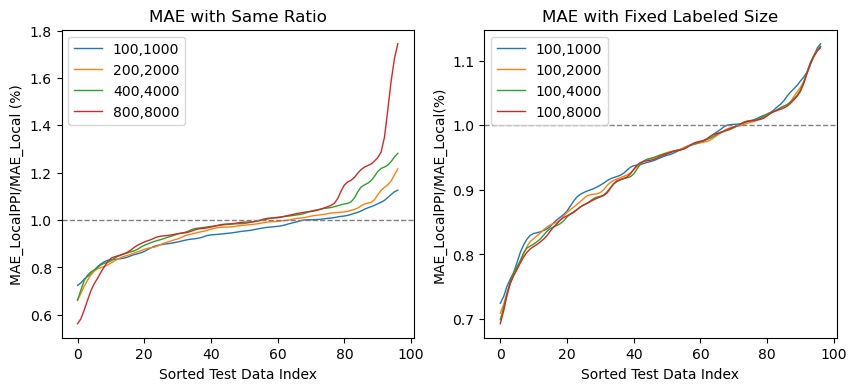

In [12]:
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
for key in [(100, 1000), (200, 2000), (400, 4000), (800, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['abs_error_ppi']/error_df_dict[key]['abs_error'])), sigma=1)
    ax1.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax1.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax1.legend()
ax1.set_title('MAE with Same Ratio')
ax1.set_xlabel('Sorted Test Data Index')
ax1.set_ylabel('MAE_LocalPPI/MAE_Local (%)')

for key in [(100, 1000), (100, 2000), (100, 4000), (100, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['abs_error_ppi']/error_df_dict[key]['abs_error'])), sigma=1)
    ax2.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax2.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax2.legend()
ax2.set_title('MAE with Fixed Labeled Size')
ax2.set_xlabel('Sorted Test Data Index')
ax2.set_ylabel('MAE_LocalPPI/MAE_Local(%)')


plt.savefig('MAE_plot.png')

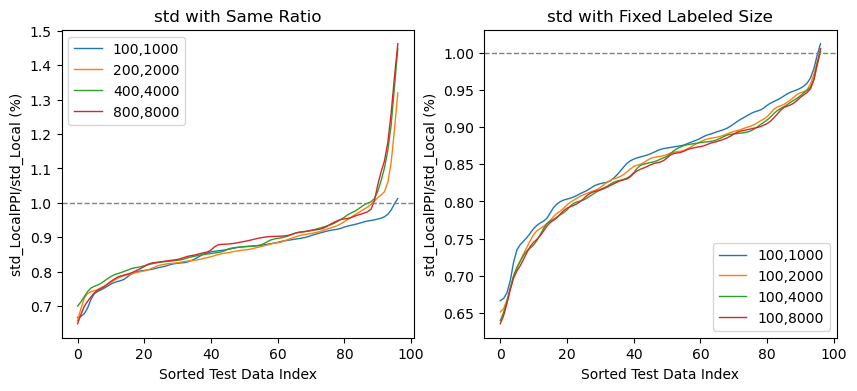

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
for key in [(100, 1000), (200, 2000), (400, 4000), (800, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['error_std_ppi']/error_df_dict[key]['error_std'])), sigma=1)
    ax1.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax1.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax1.legend()
ax1.set_title('std with Same Ratio')
ax1.set_xlabel('Sorted Test Data Index')
ax1.set_ylabel('std_LocalPPI/std_Local (%)')

for key in [(100, 1000), (100, 2000), (100, 4000), (100, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['error_std_ppi']/error_df_dict[key]['error_std'])), sigma=1)
    ax2.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax2.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax2.legend()
ax2.set_title('std with Fixed Labeled Size')
ax2.set_xlabel('Sorted Test Data Index')
ax2.set_ylabel('std_LocalPPI/std_Local (%)')


plt.savefig('std_plot.png')